In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import anndata
import scanpy as sc
sc.settings.n_jobs = 56
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

import ALLCools
from ALLCools.integration.seurat_class import SeuratIntegration

In [2]:
%matplotlib inline

In [3]:
# Define the parameters
workspace_path = 'integration_workspace'

# Load and preprocess the data

In [4]:
# Load the datasets
adata_seq = sc.read_h5ad(os.path.join(workspace_path, 'adata_seq_common_genes.h5ad'))

adata_merfish_raw = sc.read_h5ad(os.path.join(workspace_path, 'adata_merfish.h5ad'))
adata_merfish = adata_merfish_raw.copy()

In [5]:
# Normalize and scale the data
sc.pp.normalize_total(adata_seq, target_sum=1000)
sc.pp.log1p(adata_seq)
sc.pp.scale(adata_seq)

sc.pp.normalize_total(adata_merfish, target_sum=1000)
sc.pp.log1p(adata_merfish)
sc.pp.scale(adata_merfish)

In [6]:
# Merge the datasets
adata_merge = adata_seq.concatenate(adata_merfish,
                                    batch_categories=['seq', 'merfish'],
                                    batch_key='modality',
                                    index_unique=None)

/home/xingjiepan/Softwares/conda/anaconda3/envs/allcools/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [7]:
%%time
# Get the significant PCs
n_pcs = 100
sc.tl.pca(adata_merge, svd_solver='arpack', n_comps=100)

CPU times: user 7h 1min 10s, sys: 22min 11s, total: 7h 23min 21s
Wall time: 8min 43s


In [8]:
adata_list = [adata_merge[adata_merge.obs['modality'] == 'seq'],
              adata_merge[adata_merge.obs['modality'] == 'merfish']
             ]

# Integration

In [9]:
%%time
# Find the integration anchors
integrator = SeuratIntegration()
integrator.find_anchor(adata_list,
                       k_local=None,
                       key_local='X_pca',
                       k_anchor=5,
                       key_anchor='X',
                       dim_red='cca',
                       max_cc_cells=100000,
                       k_score=30,
                       k_filter=None, #why?
                       scale1=False,
                       scale2=False,
                       n_components=n_pcs,
                       n_features=200,
                       alignments=[[[0], [1]]])

Find anchors across datasets
Run CCA
Find Anchors
Score Anchors
Identified 1477136 anchors between datasets 0 and 1.
CPU times: user 5d 22h 9min 49s, sys: 1h 30min 51s, total: 5d 23h 40min 40s
Wall time: 3h 41min 35s


# Label transfer

In [10]:
%%time
cell_type_col = 'integration_partition'

transfer_results = integrator.label_transfer(
    ref=[0],
    qry=[1],
    categorical_key=[cell_type_col],
    key_dist='X_pca',
    kweight=100,
    npc=n_pcs
)

integrator.save_transfer_results_to_adata(adata_merge, transfer_results)

Initialize
Find nearest anchors
Normalize graph
Label transfer
CPU times: user 3h 8min 13s, sys: 24min 13s, total: 3h 32min 26s
Wall time: 19min 2s


In [11]:
# Assign the transfered labels and the confidence
adata_merfish_raw.obs[cell_type_col + '_transfer'] = transfer_results[cell_type_col].idxmax(axis=1
                                                                                           ).astype('category')
adata_merfish_raw.obs[cell_type_col + '_confidence'] = transfer_results[cell_type_col].max(axis=1)

n_transfered = len(np.unique(adata_merfish_raw.obs[cell_type_col + '_transfer']))
n_total = len(np.unique(adata_merge.obs[cell_type_col + '_transfer']))
print(f'Transfered {n_transfered}/{n_total} cell types.')

Transfered 46/46 cell types.


In [12]:
# Save the label transfer results for each class
partition_path = os.path.join(workspace_path, 'partitions')
partitions = np.unique(adata_merfish_raw.obs[cell_type_col + '_transfer'])

for pn in partitions:
    adata_subset = adata_merfish_raw[adata_merfish_raw.obs[cell_type_col + '_transfer'] == pn]
    adata_subset.write(os.path.join(partition_path, pn.replace('/', '-').replace(' ', '_'), 
                                    'adata_merfish_integrated.h5ad'))

Text(0.5, 1.0, 'partition_confidence')

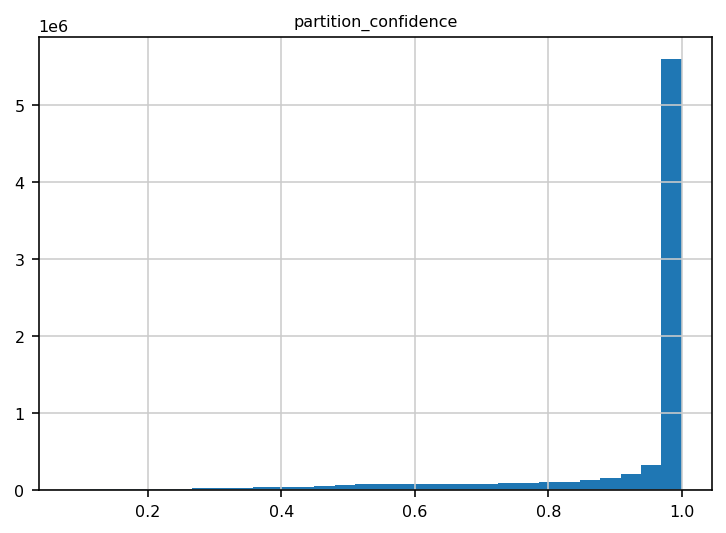

In [13]:
plt.hist(adata_merfish_raw.obs['integration_partition_confidence'], bins=30)
plt.title('partition_confidence')

# Coembedding

In [14]:
%%time
# Correct the PCs using the integration anchors
corrected = integrator.integrate(key_correct='X_pca',
                                 row_normalize=True,
                                 n_components=n_pcs,
                                 k_weight=100,
                                 sd=1,
                                 alignments=[[[0], [1]]])

adata_merge.obsm['X_pca_integrate'] = np.concatenate(corrected)

Merge datasets
[[0], [1]]


/home/xingjiepan/Softwares/conda/anaconda3/envs/allcools/lib/python3.8/site-packages/ALLCools/integration/seurat_class.py:552: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corrected = self.transform(data=np.array(corrected),


Initialize
Find nearest anchors
Normalize graph
Transform data
CPU times: user 3h 2min 23s, sys: 26min 31s, total: 3h 28min 54s
Wall time: 19min 28s


In [15]:
# Calculate KNN using the integrated PCs
sc.pp.neighbors(adata_merge, use_rep='X_pca_integrate')

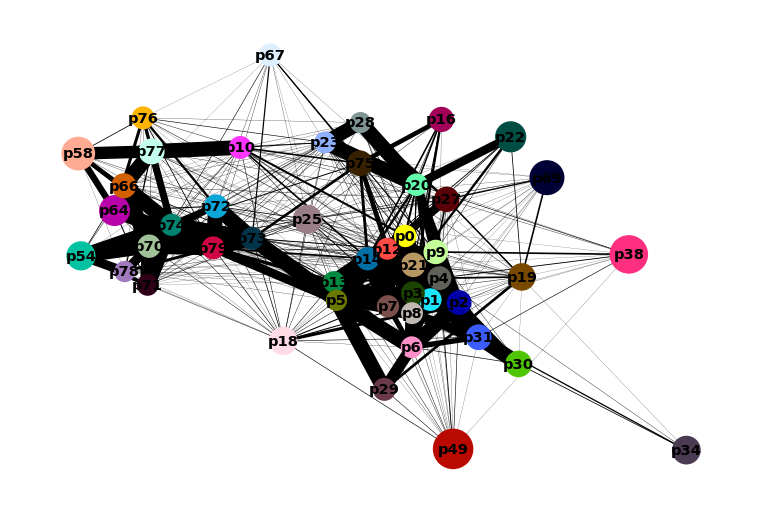

CPU times: user 13min 46s, sys: 17 s, total: 14min 3s
Wall time: 14min 2s


'integration_workspace/integration_paga_round1.png'

In [16]:
%%time
# Generate the PAGA plot for the initial arrangement of the UMAP
sc.tl.paga(adata_merge, groups=cell_type_col + '_transfer')
sc.pl.paga(adata_merge, save='_tmp.png')
shutil.move('figures/paga_tmp.png', os.path.join(workspace_path, 'integration_paga_round1.png'))

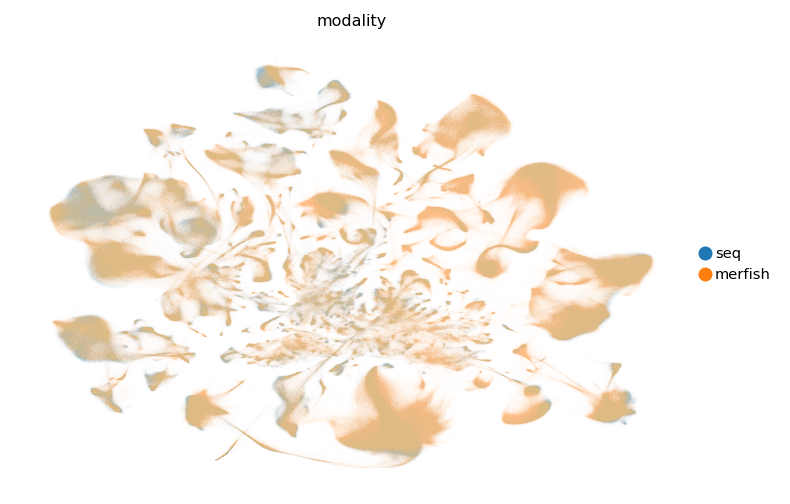

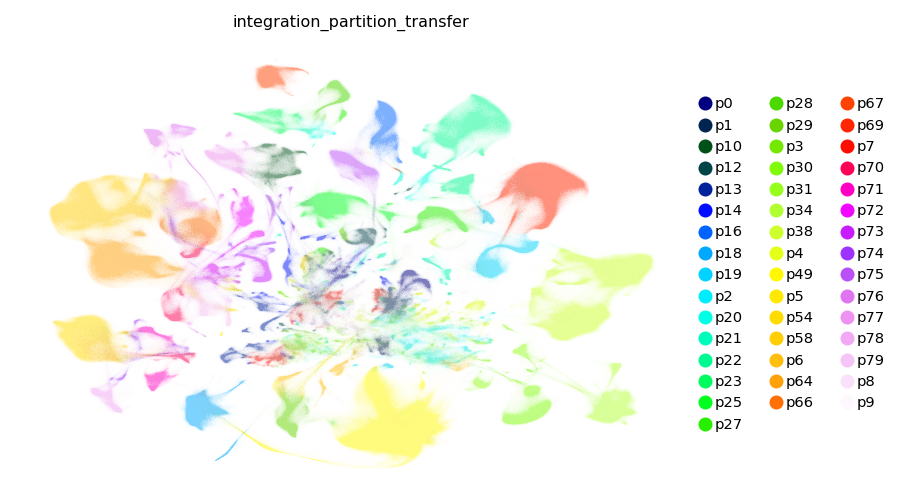

CPU times: user 3h 35s, sys: 2.5 s, total: 3h 37s
Wall time: 3h 24s


'integration_workspace/integration_umap_round1_partitions.png'

In [17]:
%%time
# Save the umap
sc.tl.umap(adata_merge, init_pos='paga', min_dist=0.5)
sc.pl.umap(adata_merge, color='modality', save='_tmp.png')
shutil.move('figures/umap_tmp.png', os.path.join(workspace_path, 'integration_umap_round1_modality.png'))
sc.pl.umap(adata_merge, color=cell_type_col + '_transfer', save='_tmp.png', palette='gist_ncar')
shutil.move('figures/umap_tmp.png', os.path.join(workspace_path, 'integration_umap_round1_partitions.png'))

In [18]:
# Save the merged adata
adata_merge.write(os.path.join(workspace_path, 'adata_merged_round1.h5ad'))